In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from torchvision.transforms import transforms

In [3]:
import numpy as np
import cv2

In [4]:
from functools import partial

In [5]:
from models import Vgg16Conv
from models import Vgg16Deconv

In [6]:
from utils import decode_predictions

In [7]:
def load_images(img_path):
    # imread from img_path
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # pytorch must normalize the pic by 
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    img.unsqueeze_(0)
    #img_s = img.numpy()
    #img_s = np.transpose(img_s, (1, 2, 0))
    #cv2.imshow("test img", img_s)
    #cv2.waitKey()
    return img

In [8]:
def store(model):
    """
    make hook for feature map
    """
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
           model.feature_maps[key] = output[0]
           model.pool_locs[key] = output[1]
        else:
           model.feature_maps[key] = output
    
    for idx, layer in enumerate(model._modules.get('features')):    
        # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key=idx))

In [9]:
def vis_layer(layer, vgg16_conv, vgg16_deconv):
    """
    visualing the layer deconv result
    """
    print(vgg16_conv.feature_maps[layer].shape)
    num_feat = vgg16_conv.feature_maps[layer].shape[1]
    
    # set other feature map activations to zero
    new_feat_map = vgg16_conv.feature_maps[layer].clone()

    # choose the max activations map
    act_lst = []
    for i in range(0, num_feat):
        choose_map = new_feat_map[0, i, :, :]
        activation = torch.max(choose_map)
        act_lst.append(activation.item())

    act_lst = np.array(act_lst)
    mark = np.argmax(act_lst)

    choose_map = new_feat_map[0, mark, :, :]
    max_activation = torch.max(choose_map)
    
    # make zeros for other feature maps
    if mark == 0:
        new_feat_map[:, 1:, :, :] = 0
    else:
        new_feat_map[:, :mark, :, :] = 0
        if mark != vgg16_conv.feature_maps[layer].shape[1] - 1:
            new_feat_map[:, mark + 1:, :, :] = 0
    
    choose_map = torch.where(choose_map==max_activation,
            choose_map,
            torch.zeros(choose_map.shape)
            )

    # make zeros for ther activations
    new_feat_map[0, mark, :, :] = choose_map
    
    # print(torch.max(new_feat_map[0, mark, :, :]))    
    print(max_activation)
    
    deconv_output = vgg16_deconv(new_feat_map, layer, mark, vgg16_conv.pool_locs)

    new_img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    # cv2.imshow('reconstruction img ' + str(layer), new_img)
    # cv2.waitKey()
    return new_img, int(max_activation)

In [10]:
def vis_forward(layer, vgg16_conv):
    """
    visualing the forward layer feature maps
    """
    
    return vgg16_conv.feature_maps[layer]

In [11]:
if __name__ == '__main__':
    pass
else:
    exit()

In [12]:
# forward processing

vgg16_conv = Vgg16Conv()
vgg16_conv.eval()

store(vgg16_conv)

In [13]:
img_path = './data/dog.jpg'
img = load_images(img_path)

conv_output = vgg16_conv(img)

pool_locs = vgg16_conv.pool_locs
# print(pool_locs)

In [14]:
print('Predicted:')
print(decode_predictions(conv_output, top=3)[0])

Predicted:
[('n02108915', 'French_bulldog', 0.28945642709732056), ('n02096585', 'Boston_bull', 0.12594109773635864), ('n02109047', 'Great_Dane', 0.11997228860855103)]


In [15]:
# backward processing

vgg16_deconv = Vgg16Deconv()
vgg16_deconv.eval()

Vgg16Deconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): ReLU()
    (2): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (8): ReLU()
    (9): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (15): ReLU()
    (16): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18

In [16]:
import matplotlib
# matplotlib.use('agg')

import matplotlib.pyplot as plt

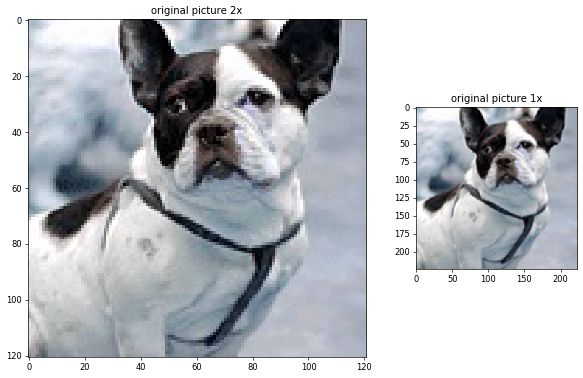

In [17]:
plt.figure(num=None, figsize=(16, 9), dpi=60)

img2 = cv2.imread(img_path)

plt.subplot(1, 2, 1)
plt.title('original picture 2x')
plt.imshow(img2)

img3 = cv2.resize(img2, (224, 224))

plt.subplot(1, 4, 3)
plt.title('original picture 1x')
plt.imshow(img3)

plt.show()

In [18]:
import collections

cfg = {}

cfg[0] = [16, 16,100,  8, 8]
cfg[1] = cfg[0]
cfg[2] = [16, 16,100,  8, 8]
cfg[3] = cfg[2]
cfg[4] = cfg[2]

cfg[5] = [16, 32,100, 16, 8]
cfg[7] = [16, 32,100, 16, 8]

cfg[10] = [16, 64,100, 32, 8]
cfg[12] = [16, 64,100, 32, 8]
cfg[14] = [16, 64,100, 32, 8]

cfg[17] = [16,128,100, 64, 8]
cfg[19] = [16,128,100, 64, 8]
cfg[21] = [16,128,100, 64, 8]

cfg[24] = [16,128,100, 64, 8]
cfg[26] = [16,128,100, 64, 8]
cfg[28] = [16,128,100, 64, 8]

In [19]:
def putImgLine(line):
    
    for i, num in enumerate(line):

        print(str(i) + ', ' + str(num))

In [20]:
def drawLayer(layer, save=False):

    print(layer)
    if layer == -1 :
      return

    plt.figure(num=None, figsize=(cfg[layer][0], cfg[layer][1]), dpi=cfg[layer][2])

    # img, activation = vis_layer(layer, vgg16_conv, vgg16_deconv)

    imgs = vis_forward(layer, vgg16_conv)[0]
    print(imgs.shape)

    # putImgLine(imgs[1][0])
    # putImgLine(imgs[1][1])

    drawImages(cfg[layer][3], cfg[layer][4], imgs, save)

In [21]:
def drawImages(rows, cols, imgs, save=False):

    print(type(imgs))
    
    for i in range(0, len(imgs)):
    # for i in range(0, 0):

        plt.subplot(rows, cols, i+1)
        img = imgs[i].detach().numpy()
        print(type(img))
        print(img.shape)
        # img = cv2.resize(img, (imgs.shape[1], imgs.shape[2]))
        plt.imshow(img)

    # plt.title(f'{layer} layer')

    if save:
        figname = 'result' + str(layer) + '.jpg'
        plt.savefig(figname)
        print('result picture has save at ./' + figname)

    plt.show()

In [35]:
print(type(vgg16_conv.features[0]))

print(vgg16_conv.features[0].weight.shape)
print(vgg16_conv.features[0].bias.shape)

<class 'torch.nn.modules.conv.Conv2d'>
torch.Size([64, 3, 3, 3])
torch.Size([64])


In [41]:
for i in range(vgg16_conv.features[0].weight.shape[0]):
    print(i)
    print(vgg16_conv.features[0].weight[i].data)
    print(vgg16_conv.features[0].bias[i].data)

0
tensor([[[-0.5537,  0.1427,  0.5290],
         [-0.5831,  0.3566,  0.7657],
         [-0.6902, -0.0480,  0.4841]],

        [[ 0.1755,  0.0099, -0.0814],
         [ 0.0441, -0.0703, -0.2604],
         [ 0.1324, -0.1728, -0.1323]],

        [[ 0.3130, -0.1659, -0.4275],
         [ 0.4752, -0.0827, -0.4870],
         [ 0.6320,  0.0193, -0.2775]]])
tensor(0.4034)
1
tensor([[[ 0.2325,  0.1267,  0.1861],
         [-0.4281, -0.2435,  0.2463],
         [-0.2507,  0.1418, -0.0055]],

        [[-0.1408, -0.2190,  0.1504],
         [-0.8413, -0.3518,  0.5640],
         [-0.2419,  0.5193,  0.5391]],

        [[-0.3143, -0.3705, -0.1309],
         [-0.4714, -0.1550,  0.3459],
         [ 0.0544,  0.5868,  0.4958]]])
tensor(0.3778)
2
tensor([[[ 0.1772,  0.5215,  0.0099],
         [-0.2718, -0.7171,  0.3129],
         [-0.0758, -0.2208,  0.3346]],

        [[ 0.3092,  0.6707,  0.0205],
         [-0.4661, -1.0697,  0.3350],
         [-0.0803, -0.3052,  0.5446]],

        [[ 0.3157,  0.4233, -0.3498]

<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(224, 224)
<class 'numpy.ndarray'>
(224, 224)
<class 'numpy.ndarray'>
(224, 224)


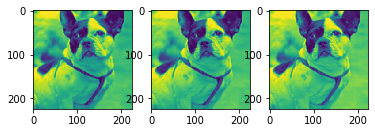

0, tensor(1.3431)
1, tensor(1.3606)
2, tensor(1.3782)
3, tensor(1.3782)
4, tensor(1.3431)
5, tensor(1.4482)
6, tensor(1.5707)
7, tensor(1.6583)
8, tensor(1.7458)
9, tensor(1.8158)
10, tensor(1.8859)
11, tensor(1.9734)
12, tensor(2.0434)
13, tensor(2.0609)
14, tensor(2.0959)
15, tensor(2.1485)
16, tensor(2.2010)
17, tensor(2.2535)
18, tensor(2.2885)
19, tensor(2.3235)
20, tensor(2.3410)
21, tensor(2.3585)
22, tensor(2.3235)
23, tensor(2.2885)
24, tensor(2.2710)
25, tensor(2.2710)
26, tensor(2.2885)
27, tensor(2.3235)
28, tensor(2.3585)
29, tensor(2.3936)
30, tensor(2.4286)
31, tensor(2.4286)
32, tensor(2.4286)
33, tensor(2.4286)
34, tensor(2.4286)
35, tensor(2.4286)
36, tensor(2.4286)
37, tensor(2.4286)
38, tensor(2.4286)
39, tensor(2.4286)
40, tensor(2.4286)
41, tensor(2.4286)
42, tensor(2.4286)
43, tensor(2.4286)
44, tensor(2.4286)
45, tensor(2.4286)
46, tensor(2.4111)
47, tensor(2.4111)
48, tensor(2.4286)
49, tensor(2.4286)
50, tensor(2.4286)
51, tensor(2.4286)
52, tensor(2.4286)
53,

In [39]:
print(type(img))
print(img.shape)
drawImages(1, 3, img[0])

putImgLine(img[0][1][0])
putImgLine(img[0][1][1])

4
torch.Size([64, 112, 112])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<class 'numpy.ndarray'>
(112, 112)
<cl

<Figure size 432x288 with 0 Axes>

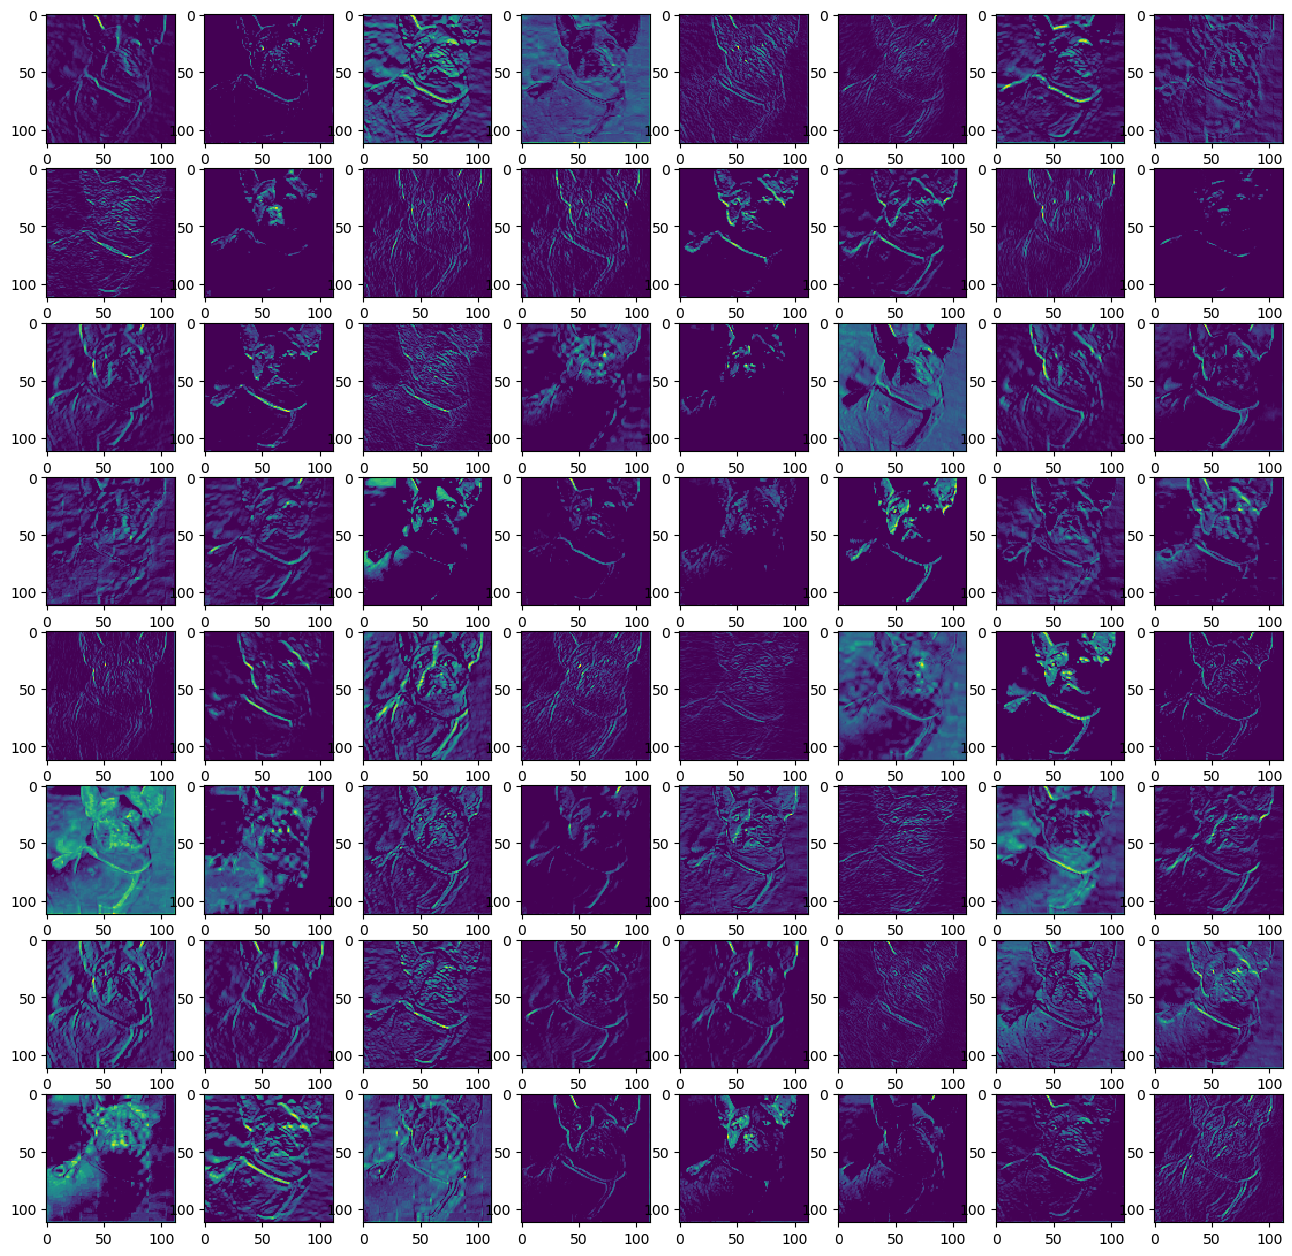

In [32]:
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.9, 
                    hspace=0.35, wspace=0.35)
    
# for idx, layer in enumerate([0,2,-1, 5,7,-1, 10,12,14, 17,19,21, 24,26,28]):
for layer in [4]:
    drawLayer(layer)
